In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar

from data import *

In [2]:
get_instruments()

{'Aluminium_futures': {'July': {'token': 58424071},
  'August': {'token': 58585095},
  'September': {'token': 58729223},
  'October': {'token': 58924295},
  'November': {'token': 59087879}}}

In [83]:
def construct_adjusted_ts(front_token, back_token, rollover):
    # load front-month and back-month price data
    df_front = get_historical_data(front_token)[['date', 'close']].rename(columns={'close': 'front'})
    df_back = get_historical_data(back_token)[['date', 'close']].rename(columns={'close': 'back'})
    df = df_front.merge(df_back, how='outer', on='date')
    df.sort_values(by='date', inplace=True)
    df.dropna(inplace=True)

    # expiry date: last thursday of a month. Rollover to next expiry date after expiry date.
    df['date'] = pd.to_datetime(df.date)
    df['expiry_date'] = df.apply(lambda x: max(week[-4] for week in calendar.monthcalendar(x.date.year, x.date.month)), axis=1)
    df['expiry_date'] = df.apply(lambda x: pd.to_datetime(f'{x.date.year}-{x.date.month}-{x.expiry_date}', format='%Y-%m-%d'), axis=1)
    df['expiry_date'] = df['expiry_date'].where(df.date <= df.expiry_date).fillna(method='bfill')

    # make a single raw price series by stitching front and back-month contracts at rollover day
    df['rollover_date'] = df['expiry_date'] - pd.Timedelta(rollover, unit='D')
    mask = (df.rollover_date <= df.date) & (df.date <= df.expiry_date)
    df['rolled_close'] = df['back'].where(mask, df.front)

    # backwards panama adjustment
    df['last_day'] = df['rollover_date'] != df['rollover_date'].shift(-1)
    df['shift'] = ((df['rolled_close'].shift(-1) - df['rolled_close']) * df['last_day']).fillna(0)
    df['back_cum_shift'] = df['shift'][::-1].cumsum()
    df['adjusted_close'] = df['rolled_close'] + df['back_cum_shift']
    
    return df


df = construct_adjusted_ts(58424071, 58585095, 5)
df

date   front    back expiry_date rollover_date  rolled_close  \
25   2011-04-01  117.85  118.15  2011-04-28    2011-04-23        117.85   
29   2011-04-06  118.70  118.65  2011-04-28    2011-04-23        118.70   
30   2011-04-07  118.80  119.85  2011-04-28    2011-04-23        118.80   
31   2011-04-08  119.95  120.30  2011-04-28    2011-04-23        119.95   
33   2011-04-11  119.50  120.45  2011-04-28    2011-04-23        119.50   
...         ...     ...     ...         ...           ...           ...   
2752 2021-06-25  192.85  195.50  2021-07-29    2021-07-24        192.85   
2753 2021-06-28  191.80  194.40  2021-07-29    2021-07-24        191.80   
2754 2021-06-29  196.75  197.80  2021-07-29    2021-07-24        196.75   
2755 2021-06-30  199.85  198.75  2021-07-29    2021-07-24        199.85   
2756 2021-07-01  198.15  200.00  2021-07-29    2021-07-24        198.15   

      last_day  shift  back_cum_shift  adjusted_close  
25       False    0.0          -77.65           40.20  
29       False    0.0          -77.65           41.05  
30       False    0.0          -77.65           41.15  
31       False   -0.0          -77.65           42.30  
33       False   -0.0          -77.65           41.85  
...        ...    ...             ...             ...  
2752     False   -0.0            0.00          192.85  
2753     False    0.0            0.00          191.80  
2754     False    0.0            0.00          196.75  
2755     False   -0.0            0.00          199.85  
2756      True    0.0            0.00          198.15  

[2664 rows x 10 columns]

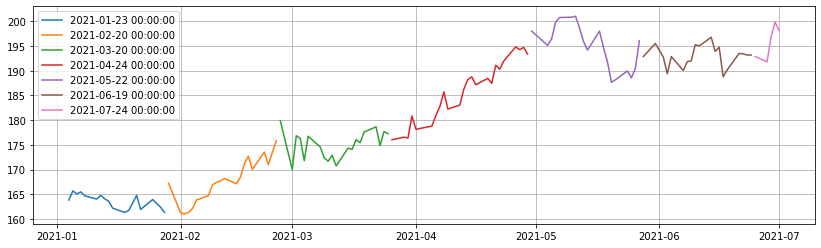

In [84]:
df2 = df[df.date >= '2021-01-01']

plt.figure(figsize=(14,4))
for g, d in df2.groupby('rollover_date'):
    plt.plot(pd.to_datetime(d.date), d.rolled_close, label=g)
plt.legend()
plt.grid()
plt.show()

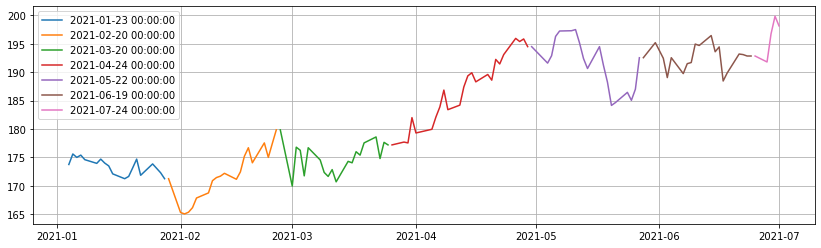

In [85]:
df2 = df[df.date >= '2021-01-01']

plt.figure(figsize=(14,4))
for g, d in df2.groupby('rollover_date'):
    plt.plot(pd.to_datetime(d.date), d.adjusted_close, label=g)
plt.legend()
plt.grid()
plt.show()